In [ ]:
# full "Batch 1" of CIFAR-10, which contains 10,000 images across ALL 10 categories (Airplanes, Cars, Birds, Cats, Deer, Dogs, Frogs, Horses, Ships, Trucks).

Running Entropy Experiment on: mps
Injecting 20.0% Noise (Simulating Data Conflicts)...
Total Samples: 10000 | Clean: 8000 | Conflicting: 2000
Training Model on Conflicting Data...
Epoch 1/10 | Loss: 2.1163
Epoch 2/10 | Loss: 1.8994
Epoch 3/10 | Loss: 1.6903
Epoch 4/10 | Loss: 1.4595
Epoch 5/10 | Loss: 1.2917
Epoch 6/10 | Loss: 1.1355
Epoch 7/10 | Loss: 0.9311
Epoch 8/10 | Loss: 0.7447
Epoch 9/10 | Loss: 0.6163
Epoch 10/10 | Loss: 0.4434
Calculating Entropy (Uncertainty)...


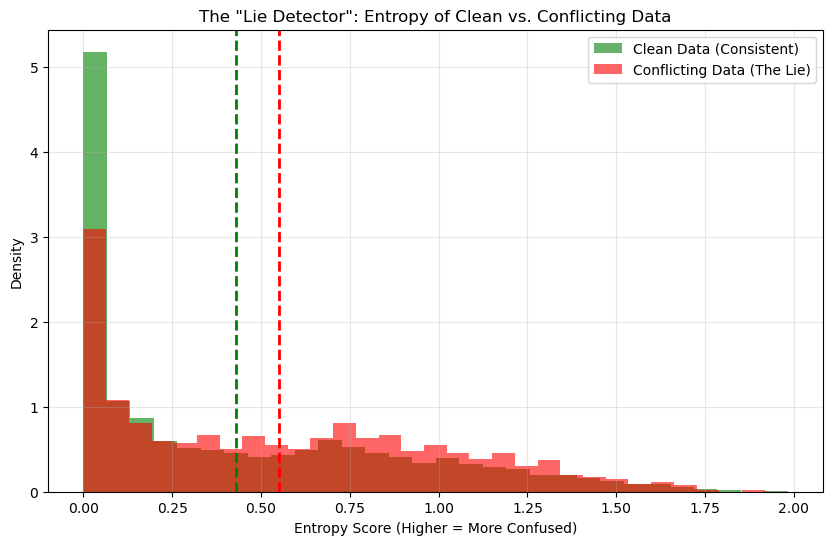

Average Entropy (Clean): 0.4309
Average Entropy (Conflict): 0.5515


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

# 1. Setup Paths to your existing Git structure
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.data.cifar_loader import load_cifar_batch
from src.data.cifar_dataset import CIFAR10Dataset
from src.models.resnet import ResNet18CIFAR
from src.analysis.entropy import calculate_entropy  # The tool we just made!

# --- CONFIGURATION ---
NOISE_RATE = 0.2  # We lie about 20% of the data
BATCH_SIZE = 128
EPOCHS = 10       # Enough to learn patterns, but not enough to memorize everything perfectly
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(f"Running Entropy Experiment on: {device}")

# --- PART A: PREPARE THE DATA (The Business Scenario) ---
# We simulate a "Bad Database" where 20% of records are wrong.

# 1. Load Data
data_path = '/Users/daulet/Desktop/data centric ai/cifar-10-batches-py' # Check your path!
train_batch_1 = os.path.join(data_path, 'data_batch_1')
x_train, y_train = load_cifar_batch(train_batch_1)

# 2. Inject "Conflicting Labels" (The Lie)
print(f"Injecting {NOISE_RATE*100}% Noise (Simulating Data Conflicts)...")
num_samples = len(y_train)
num_noisy = int(NOISE_RATE * num_samples)

# We create a mask to track WHICH rows are corrupted (for our analysis later)
noisy_indices = np.random.choice(num_samples, num_noisy, replace=False)
clean_indices = np.setdiff1d(np.arange(num_samples), noisy_indices)

y_train_corrupted = np.array(y_train).copy()

# Randomly flip labels for the noisy group
for idx in noisy_indices:
    original_label = y_train[idx]
    # Pick a random WRONG label
    possible_labels = list(range(10))
    possible_labels.remove(original_label)
    y_train_corrupted[idx] = np.random.choice(possible_labels)

print(f"Total Samples: {num_samples} | Clean: {len(clean_indices)} | Conflicting: {len(noisy_indices)}")

# 3. Create Dataset & Loader
# Use standard normalization transforms
import torchvision.transforms as T
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

dataset = CIFAR10Dataset(x_train, y_train_corrupted, transform=transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False) # Shuffle=False to keep indices aligned!

# --- PART B: TRAIN THE MODEL (The "Learning" Phase) ---
# The model tries to learn rules, but 20% of the data breaks those rules.

model = ResNet18CIFAR(num_classes=10).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

print("Training Model on Conflicting Data...")
model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss/len(loader):.4f}")

# --- PART C: MEASURE ENTROPY (The "Lie Detector") ---
# Now we ask: "How confused are you about each image?"

print("Calculating Entropy (Uncertainty)...")
model.eval()
all_entropies = []

with torch.no_grad():
    for imgs, _ in loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        entropies = calculate_entropy(logits)
        all_entropies.extend(entropies.cpu().numpy())

all_entropies = np.array(all_entropies)

# Split results into two groups
clean_entropy = all_entropies[clean_indices]
noisy_entropy = all_entropies[noisy_indices]

# --- PART D: VISUALIZE (The Business Insight) ---
plt.figure(figsize=(10, 6))

# Plot histograms
plt.hist(clean_entropy, bins=30, alpha=0.6, color='green', label='Clean Data (Consistent)', density=True)
plt.hist(noisy_entropy, bins=30, alpha=0.6, color='red', label='Conflicting Data (The Lie)', density=True)

plt.axvline(clean_entropy.mean(), color='green', linestyle='dashed', linewidth=2)
plt.axvline(noisy_entropy.mean(), color='red', linestyle='dashed', linewidth=2)

plt.title('The "Lie Detector": Entropy of Clean vs. Conflicting Data')
plt.xlabel('Entropy Score (Higher = More Confused)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Average Entropy (Clean): {clean_entropy.mean():.4f}")
print(f"Average Entropy (Conflict): {noisy_entropy.mean():.4f}")

In [ ]:
#"Pure" Cat vs. Dog experiment

Filtering for ONLY Cats and Dogs...
Original Size: 10000 -> Filtered Size: 1953
Training Binary Model (Cat vs. Dog)...


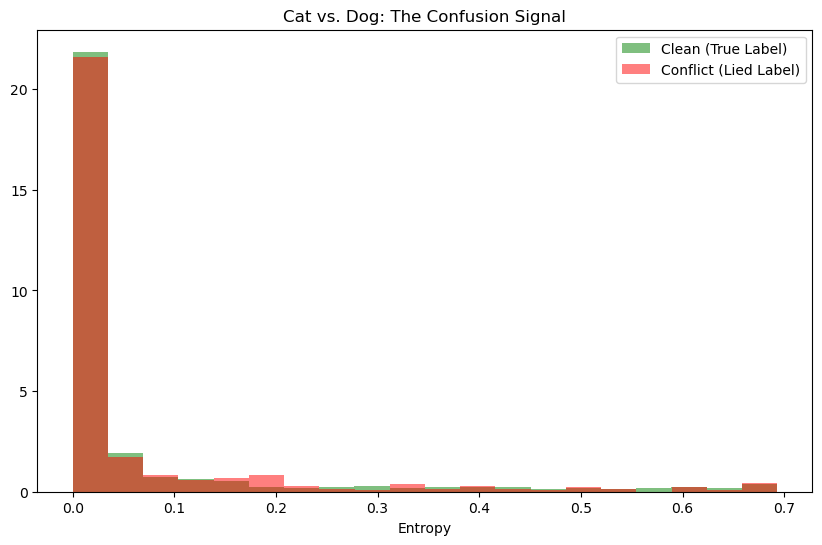

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from src.data.cifar_dataset import CIFAR10Dataset
from src.models.resnet import ResNet18CIFAR
from src.analysis.entropy import calculate_entropy
import torchvision.transforms as T
import matplotlib.pyplot as plt

# --- CONFIG ---
CLASSES_TO_KEEP = [3, 5] # 3=Cat, 5=Dog
NOISE_RATE = 0.2
BATCH_SIZE = 64

# 1. Load Data (Again)
print("Filtering for ONLY Cats and Dogs...")
x_train, y_train = load_cifar_batch(train_batch_1)

# 2. Filter the Arrays
# We create a "mask" that is True only for labels 3 and 5
mask = np.isin(y_train, CLASSES_TO_KEEP)
x_binary = x_train[mask]
y_binary = np.array(y_train)[mask]

# Remap labels to 0 and 1 (0=Cat, 1=Dog) for binary classification
# This makes the model's job very specific
y_binary = np.where(y_binary == 3, 0, 1)

print(f"Original Size: {len(y_train)} -> Filtered Size: {len(y_binary)}")

# 3. Inject Noise (The Lie)
num_samples = len(y_binary)
num_noisy = int(NOISE_RATE * num_samples)
noisy_indices = np.random.choice(num_samples, num_noisy, replace=False)
clean_indices = np.setdiff1d(np.arange(num_samples), noisy_indices)

y_corrupted = y_binary.copy()
# Flip the label: If 0 make it 1, if 1 make it 0
y_corrupted[noisy_indices] = 1 - y_corrupted[noisy_indices]

# 4. Train
transform = T.Compose([T.ToTensor(), T.Normalize((0.5,), (0.5,))])
dataset = CIFAR10Dataset(x_binary, y_corrupted, transform=transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# We change num_classes=2 because we only have Cats and Dogs now
model = ResNet18CIFAR(num_classes=2).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

print("Training Binary Model (Cat vs. Dog)...")
model.train()
for epoch in range(10):
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

# 5. Measure Entropy
model.eval()
clean_entropies = []
noisy_entropies = []

# We need to check each image one by one to sort them into Clean vs Noisy lists
# (Re-loading without shuffle to match indices)
eval_loader = DataLoader(dataset, batch_size=1, shuffle=False)

with torch.no_grad():
    for i, (img, _) in enumerate(eval_loader):
        img = img.to(device)
        logits = model(img)
        entropy = calculate_entropy(logits).item()
        
        if i in noisy_indices:
            noisy_entropies.append(entropy)
        else:
            clean_entropies.append(entropy)

# 6. Plot
plt.figure(figsize=(10, 6))
plt.hist(clean_entropies, bins=20, alpha=0.5, color='green', label='Clean (True Label)', density=True)
plt.hist(noisy_entropies, bins=20, alpha=0.5, color='red', label='Conflict (Lied Label)', density=True)
plt.title('Cat vs. Dog: The Confusion Signal')
plt.xlabel('Entropy')
plt.legend()
plt.show()

In [ ]:
#The Entropy Timeline

Loading and Poisoning Data...
Starting Measurement Loop on mps...
Epoch 1: Clean Ent=1.743 | Conflict Ent=1.763
Epoch 2: Clean Ent=1.557 | Conflict Ent=1.611
Epoch 3: Clean Ent=1.586 | Conflict Ent=1.697
Epoch 4: Clean Ent=1.312 | Conflict Ent=1.502
Epoch 5: Clean Ent=1.051 | Conflict Ent=1.331
Epoch 6: Clean Ent=0.781 | Conflict Ent=0.991
Epoch 7: Clean Ent=0.527 | Conflict Ent=0.704
Epoch 8: Clean Ent=0.359 | Conflict Ent=0.527
Epoch 9: Clean Ent=0.225 | Conflict Ent=0.275
Epoch 10: Clean Ent=0.130 | Conflict Ent=0.182
Epoch 11: Clean Ent=0.074 | Conflict Ent=0.103
Epoch 12: Clean Ent=0.062 | Conflict Ent=0.098
Epoch 13: Clean Ent=0.039 | Conflict Ent=0.069
Epoch 14: Clean Ent=0.186 | Conflict Ent=0.236
Epoch 15: Clean Ent=0.111 | Conflict Ent=0.155


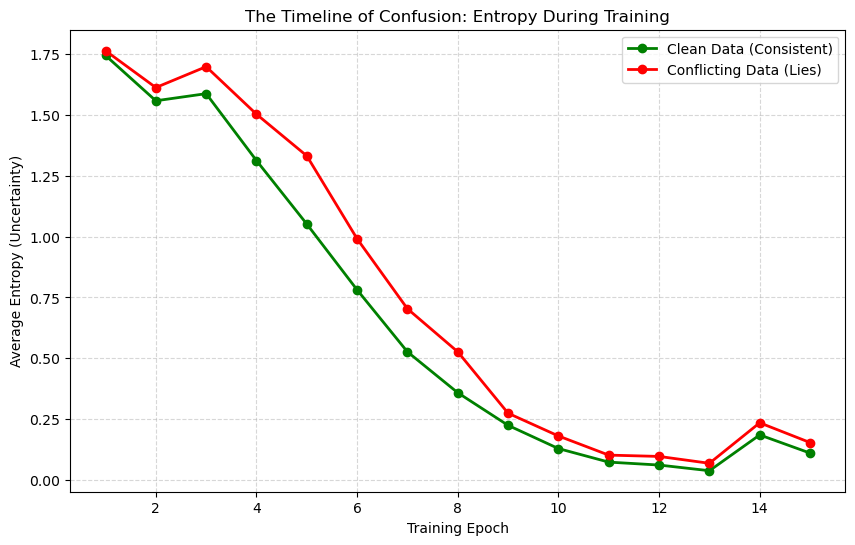

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

# Setup
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.data.cifar_loader import load_cifar_batch
from src.data.cifar_dataset import CIFAR10Dataset
from src.models.resnet import ResNet18CIFAR
from src.analysis.entropy import calculate_entropy
import torchvision.transforms as T

# --- CONFIG ---
NOISE_RATE = 0.2
EPOCHS = 15 # Run a bit longer to see the divergence
BATCH_SIZE = 128
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 1. Prepare Data (Standard 10-Class with 20% Lies)
print("Loading and Poisoning Data...")
data_path = '/Users/daulet/Desktop/data centric ai/cifar-10-batches-py/data_batch_1'
x_train, y_train = load_cifar_batch(data_path)

# Inject Noise
num_samples = len(y_train)
num_noisy = int(NOISE_RATE * num_samples)
noisy_indices = np.random.choice(num_samples, num_noisy, replace=False)
clean_indices = np.setdiff1d(np.arange(num_samples), noisy_indices)

y_corrupted = np.array(y_train).copy()
for idx in noisy_indices:
    original = y_train[idx]
    opts = list(range(10))
    opts.remove(original)
    y_corrupted[idx] = np.random.choice(opts)

# Create Dataset
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
dataset = CIFAR10Dataset(x_train, y_corrupted, transform=transform)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# We need a separate loader that DOES NOT SHUFFLE to measure specific indices
eval_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# 2. Setup Model & Metrics Storage
model = ResNet18CIFAR(num_classes=10).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Storage for the graph
history = {
    'epoch': [],
    'clean_entropy': [],
    'noisy_entropy': []
}

print(f"Starting Measurement Loop on {device}...")

for epoch in range(EPOCHS):
    # --- A. TRAIN ---
    model.train()
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    
    # --- B. MEASURE (The Probe) ---
    model.eval()
    clean_entropies = []
    noisy_entropies = []
    
    # We use 'no_grad' to speed up measurement
    with torch.no_grad():
        # Iterate through data in order (shuffle=False)
        # We need to track the "global index" to know if an image is Clean or Noisy
        current_idx = 0
        
        for imgs, _ in eval_loader:
            imgs = imgs.to(device)
            batch_size = imgs.size(0)
            
            # Calculate Entropy for this batch
            logits = model(imgs)
            batch_entropies = calculate_entropy(logits).cpu().numpy()
            
            # Sort them into Clean vs. Noisy buckets
            batch_indices = np.arange(current_idx, current_idx + batch_size)
            
            # Check which indices in this batch are "noisy"
            # np.isin returns a boolean mask
            is_noisy = np.isin(batch_indices, noisy_indices)
            
            noisy_entropies.extend(batch_entropies[is_noisy])
            clean_entropies.extend(batch_entropies[~is_noisy])
            
            current_idx += batch_size

    # Average them for this epoch
    avg_clean = np.mean(clean_entropies)
    avg_noisy = np.mean(noisy_entropies)
    
    history['epoch'].append(epoch + 1)
    history['clean_entropy'].append(avg_clean)
    history['noisy_entropy'].append(avg_noisy)
    
    print(f"Epoch {epoch+1}: Clean Ent={avg_clean:.3f} | Conflict Ent={avg_noisy:.3f}")

# 3. PLOT THE TIMELINE
plt.figure(figsize=(10, 6))
plt.plot(history['epoch'], history['clean_entropy'], 'g-o', label='Clean Data (Consistent)', linewidth=2)
plt.plot(history['epoch'], history['noisy_entropy'], 'r-o', label='Conflicting Data (Lies)', linewidth=2)

plt.title('The Timeline of Confusion: Entropy During Training')
plt.xlabel('Training Epoch')
plt.ylabel('Average Entropy (Uncertainty)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Loading Data & Creating Synthetic Metadata...
Training Fusion Model (Image + Metadata agree)...
Epoch 1/5 | Loss: 1.6141
Epoch 2/5 | Loss: 0.3196
Epoch 3/5 | Loss: 0.0302
Epoch 4/5 | Loss: 0.0117
Epoch 5/5 | Loss: 0.0072

--- STARTING THE FEATURE WAR ---
Testing on 500 conflicting samples...

--- RESULTS: WHO WON? ---
Image Wins: 56 (Model trusted the Visuals)
Metadata Wins: 408 (Model trusted the Text)
Confusion: 36 (Model guessed something else entirely)


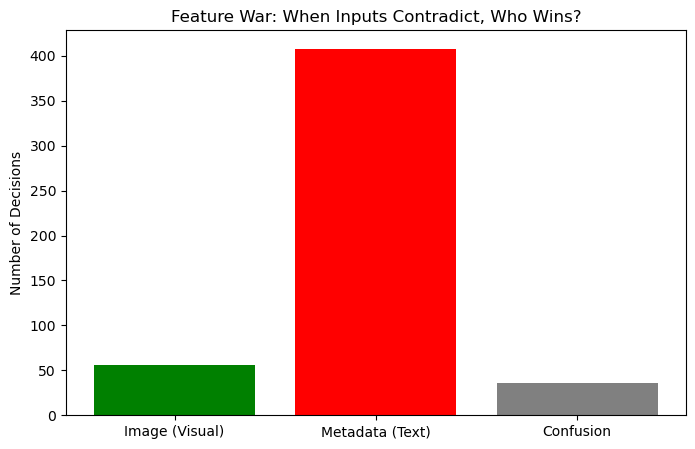

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import torchvision.transforms as T

# Setup
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.data.cifar_loader import load_cifar_batch

# --- THE FIX IS HERE ---
from src.models.fusion import FusionNet 
# -----------------------

# --- CONFIG ---
BATCH_SIZE = 64
EPOCHS = 5 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 1. PREPARE DATA (Simulating Metadata)
print("Loading Data & Creating Synthetic Metadata...")
data_path = '/Users/daulet/Desktop/data centric ai/cifar-10-batches-py/data_batch_1'
x_raw, y_raw = load_cifar_batch(data_path)

# Transform Images
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
# Convert list of images to a single tensor stack
x_tensor = torch.stack([transform(img) for img in x_raw])
y_tensor = torch.tensor(y_raw, dtype=torch.long)

# Create "Perfect" Metadata (One-Hot Encoding of the TRUE label)
# If label is 3 (Cat), vector is [0, 0, 0, 1, 0, ...]
meta_tensor = F.one_hot(y_tensor, num_classes=10).float()

# Create Dataset
train_dataset = TensorDataset(x_tensor, meta_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 2. TRAIN THE FUSION MODEL
model = FusionNet(num_classes=10).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

print("Training Fusion Model (Image + Metadata agree)...")
model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for imgs, metas, labels in train_loader:
        imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs, metas) # Feed BOTH inputs
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss/len(train_loader):.4f}")

# 3. THE FEATURE WAR (Test Phase)
print("\n--- STARTING THE FEATURE WAR ---")
# We will take 500 examples and FLIP the metadata.
# Image = Dog (Label 5) | Metadata says = Cat (Label 3)

model.eval()
image_wins = 0
metadata_wins = 0
confusion = 0

# Pick 500 random samples
indices = np.random.choice(len(x_tensor), 500, replace=False)
samples_img = x_tensor[indices].to(device)
samples_true_labels = y_tensor[indices].to(device)

# Create LYING Metadata
# We shift the label by 1 (e.g., Dog(5) -> Frog(6))
# This ensures the Metadata is ALWAYS wrong and disagrees with the image.
fake_labels = (samples_true_labels + 1) % 10 
samples_bad_meta = F.one_hot(fake_labels, num_classes=10).float().to(device)

print(f"Testing on {len(indices)} conflicting samples...")

with torch.no_grad():
    outputs = model(samples_img, samples_bad_meta)
    _, predictions = torch.max(outputs, 1)
    
    for i in range(len(predictions)):
        pred = predictions[i].item()
        true_lbl = samples_true_labels[i].item() # What the Image shows
        fake_lbl = fake_labels[i].item()         # What the Metadata says
        
        if pred == true_lbl:
            image_wins += 1
        elif pred == fake_lbl:
            metadata_wins += 1
        else:
            confusion += 1

# 4. RESULTS
print("\n--- RESULTS: WHO WON? ---")
print(f"Image Wins: {image_wins} (Model trusted the Visuals)")
print(f"Metadata Wins: {metadata_wins} (Model trusted the Text)")
print(f"Confusion: {confusion} (Model guessed something else entirely)")

# Visualize
labels = ['Image (Visual)', 'Metadata (Text)', 'Confusion']
counts = [image_wins, metadata_wins, confusion]
colors = ['green', 'red', 'gray']

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=colors)
plt.title('Feature War: When Inputs Contradict, Who Wins?')
plt.ylabel('Number of Decisions')
plt.show()